[1/8] Loading file: C:\Users\user\Data-Science-main\Online retail.xlsx
     Loaded shape: (7500, 1)
shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
                                                                                                                                                                                                         burgers,meatballs,eggs
                                                                                                                                                                                                                        chutney
                                                                                                                                                                                                                 turkey,avocado
[2/8

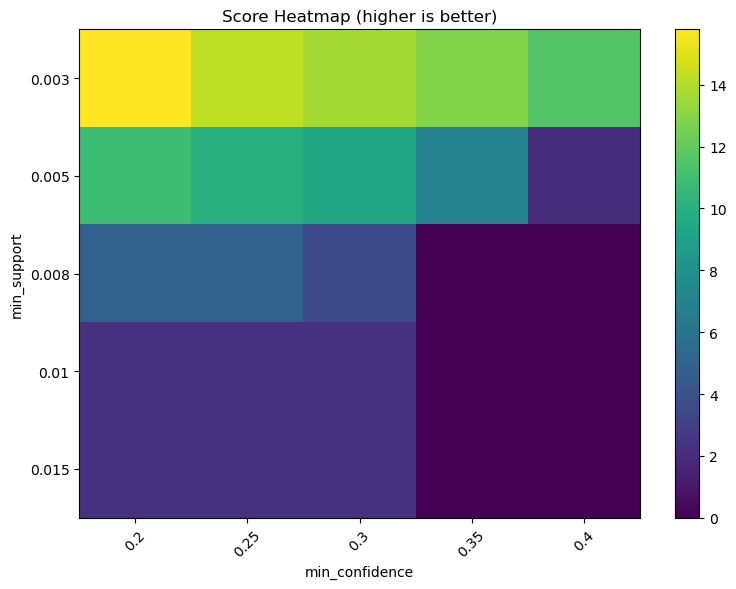

[8/8] Plotting (heatmap + network) ...


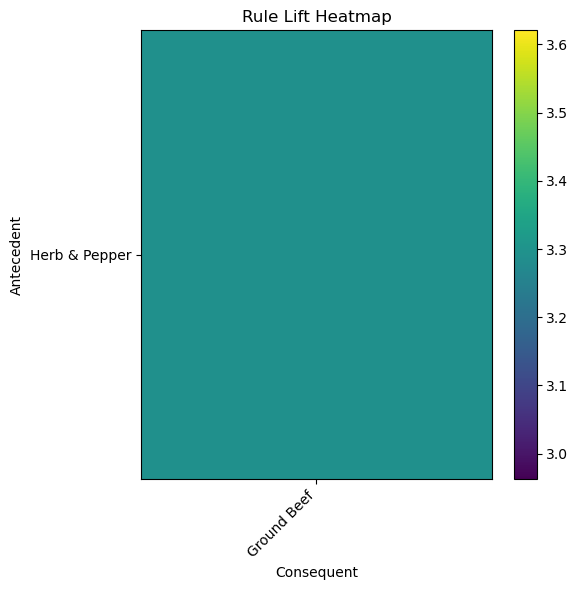

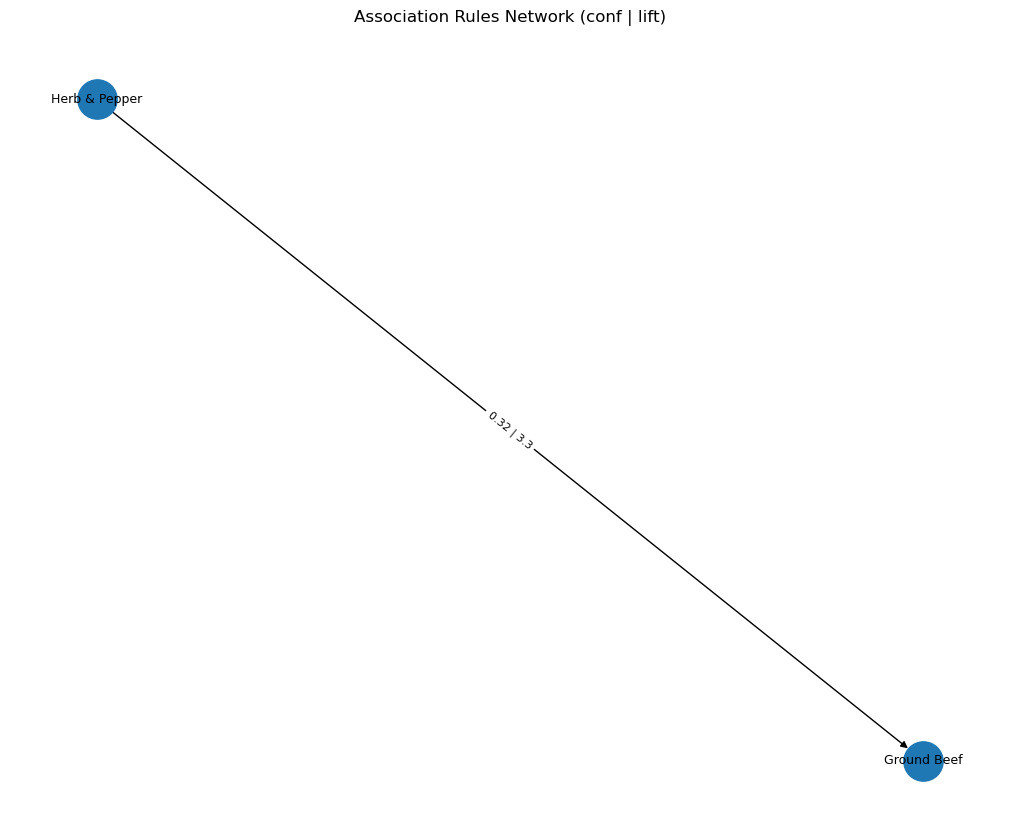


DONE.


In [19]:
# ============================================
# Association Rules (Debug-Friendly Version)
# - Verbose prints so you SEE progress
# - Auto-relax thresholds if no rules found
# - Always prints a top-rules table (even if plots fail)
# ============================================
# pip install pandas mlxtend openpyxl
# Optional (for network graph): pip install networkx

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
from math import log1p
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mlxtend.frequent_patterns import apriori, association_rules

# Optional network graph
try:
    import networkx as nx
    NX_AVAILABLE = True
except Exception:
    NX_AVAILABLE = False

# Optional Excel engine check
try:
    import openpyxl  # noqa: F401
    OPENPYXL = True
except Exception:
    OPENPYXL = False


# ---------- CONFIG ----------
DATA_PATH = r"C:\Users\user\Data-Science-main\Online retail.xlsx"  # <-- CHANGE THIS
COUNTRY_FILTER = None   # e.g., "United Kingdom" or None

MIN_SUPPORT = 0.01      # will auto-relax if no rules
MIN_CONFIDENCE = 0.30   # will auto-relax if no rules
MIN_LIFT = 3.0
MAX_LEN = 3
PRUNE_MIN_ITEM_FREQ = 2
TOP_N_VIS = 20
OUT_DIR = Path(".")
FREQ_OUT = OUT_DIR / "frequent_itemsets.csv"
RULES_OUT = OUT_DIR / "association_rules.csv"
# ---------------------------


def load_data(data_path: str) -> pd.DataFrame:
    p = Path(data_path)
    print(f"[1/8] Loading file: {p}")
    if not p.exists():
        raise FileNotFoundError(f"File not found: {p}")
    if p.suffix.lower() in {".xls", ".xlsx"}:
        if not OPENPYXL:
            raise RuntimeError("openpyxl is required. Install via: pip install openpyxl")
        df = pd.read_excel(p, engine="openpyxl")
    elif p.suffix.lower() == ".csv":
        df = pd.read_csv(p)
    else:
        df = pd.read_excel(p, engine="openpyxl")
    print("     Loaded shape:", df.shape)
    print(df.head(3).to_string(index=False))
    return df


def prepare_transactions(df: pd.DataFrame, country_filter: str | None = None) -> pd.DataFrame:
    print("[2/8] Preparing basket (one-hot) ...")
    df = df.copy()
    df.columns = [c.strip().lower() for c in df.columns]
    cols = set(df.columns)
    print("     Columns:", sorted(cols))

    if {"invoiceno", "description", "quantity"} <= cols:
        df = df.dropna(subset=["invoiceno", "description"])
        df["invoiceno"] = df["invoiceno"].astype(str)
        df = df[~df["invoiceno"].str.startswith("C")]  # remove cancellations

        df["quantity"] = pd.to_numeric(df["quantity"], errors="coerce").fillna(0)
        df = df[df["quantity"] > 0]

        if "unitprice" in df.columns:
            df["unitprice"] = pd.to_numeric(df["unitprice"], errors="coerce").fillna(0)
            df = df[df["unitprice"] >= 0]

        df["description"] = df["description"].astype(str).str.strip().str.title()

        if country_filter and "country" in df.columns:
            df["country"] = df["country"].astype(str).str.strip()
            before = len(df)
            df = df[df["country"].str.lower() == country_filter.lower()]
            print(f"     Country filter '{country_filter}': {before} -> {len(df)} rows")

        df = df.drop_duplicates(subset=["invoiceno", "description", "quantity"])

        basket = (
            df.groupby(["invoiceno", "description"], as_index=False)["quantity"]
              .sum()
              .pivot(index="invoiceno", columns="description", values="quantity")
              .fillna(0)
        )
        basket = (basket > 0).astype("uint8")
        print("     Basket shape:", basket.shape)
        return basket

    if len(cols) == 1:
        only_col = list(cols)[0]
        temp = (df[only_col].dropna().astype(str)
                  .apply(lambda s: [x.strip().title() for x in s.split(",") if x.strip()]))
        rows = []
        for i, items in enumerate(temp, start=1):
            for it in items:
                rows.append((f"INV-{i}", it, 1))
        tmp = pd.DataFrame(rows, columns=["invoiceno", "description", "quantity"])
        basket = (
            tmp.groupby(["invoiceno", "description"], as_index=False)["quantity"]
               .sum()
               .pivot(index="invoiceno", columns="description", values="quantity")
               .fillna(0)
        )
        basket = (basket > 0).astype("uint8")
        print("     Basket shape:", basket.shape)
        return basket

    raise ValueError("Unsupported input shape. Need Online Retail-like columns or a single items column.")


def prune_rare_items(basket: pd.DataFrame, min_item_freq: int) -> pd.DataFrame:
    print("[3/8] Pruning ultra-rare items ...")
    if min_item_freq <= 1:
        print("     Skipped (min_item_freq <= 1)")
        return basket
    col_sums = basket.sum(axis=0)
    keep = col_sums[col_sums >= min_item_freq].index
    pruned = basket[keep]
    print(f"     Items: {basket.shape[1]} -> {pruned.shape[1]} (kept >= {min_item_freq} baskets)")
    return pruned


def mine_rules(basket: pd.DataFrame, min_support: float, min_conf: float, min_lift: float, max_len: int):
    print(f"[4/8] Mining rules (support={min_support}, conf={min_conf}, lift>={min_lift}, max_len={max_len}) ...")
    if basket.empty or basket.shape[1] == 0:
        print("     Basket is empty.")
        return pd.DataFrame(), pd.DataFrame()
    freq = apriori(basket, min_support=min_support, use_colnames=True, max_len=max_len)
    print("     Frequent itemsets:", freq.shape)
    if freq.empty:
        return freq, pd.DataFrame()
    rules = association_rules(freq, metric="confidence", min_threshold=min_conf)
    print("     Raw rules:", rules.shape)
    if rules.empty:
        return freq, rules
    rules = rules[rules["lift"] >= min_lift].copy()
    print("     After lift filter:", rules.shape)
    rules["antecedents_str"] = rules["antecedents"].apply(lambda s: ", ".join(sorted(list(s))))
    rules["consequents_str"] = rules["consequents"].apply(lambda s: ", ".join(sorted(list(s))))
    rules = rules.sort_values(["lift","confidence","support"], ascending=False, kind="mergesort")
    return freq.sort_values("support", ascending=False), rules


def reduce_redundant_rules(rules: pd.DataFrame) -> pd.DataFrame:
    print("[5/8] Reducing redundant rules ...")
    if rules.empty:
        print("     No rules to reduce.")
        return rules
    df = rules.copy()
    df["ante_set"] = df["antecedents"].apply(lambda x: frozenset(x))
    df["cons_set"] = df["consequents"].apply(lambda x: frozenset(x))
    keep_mask = np.ones(len(df), dtype=bool)
    for cons, grp in df.groupby("cons_set"):
        idxs = grp.sort_values(["confidence","lift","support"], ascending=False).index.tolist()
        seen_ante = []
        for i in idxs:
            a = df.at[i, "ante_set"]
            if any(sa.issubset(a) for sa in seen_ante):
                keep_mask[df.index.get_loc(i)] = False
            else:
                seen_ante.append(a)
    reduced = df[keep_mask].drop(columns=["ante_set","cons_set"])
    reduced = reduced.sort_values(["lift","confidence","support"], ascending=False, kind="mergesort")
    print("     Reduced rules:", reduced.shape)
    return reduced


def ensure_some_rules(basket: pd.DataFrame,
                      start_support: float, start_conf: float,
                      min_lift: float, max_len: int):
    """Try initial thresholds; if no rules, auto-relax progressively."""
    freq, rules = mine_rules(basket, start_support, start_conf, min_lift, max_len)
    if not rules.empty:
        return freq, rules, start_support, start_conf

    print("     No rules found — auto-relaxing thresholds...")
    support_try = [start_support, 0.008, 0.005, 0.003, 0.002, 0.001]
    conf_try    = [start_conf, 0.25, 0.20, 0.15]
    lift_try    = [min_lift, 2.0, 1.5, 1.2, 1.0]

    for s in support_try:
        for c in conf_try:
            for L in lift_try:
                f, r = mine_rules(basket, s, c, L, max_len)
                if not r.empty:
                    print(f"     SUCCESS with support={s}, confidence={c}, lift>={L}")
                    return f, r, s, c

    print("     Still no rules; consider: removing COUNTRY_FILTER, lowering PRUNE_MIN_ITEM_FREQ, or cleaning data.")
    return freq, rules, start_support, start_conf


def plot_score_heatmap(grid: pd.DataFrame):
    if grid.empty:
        print("     No grid results to plot.")
        return
    piv = grid.pivot(index="min_support", columns="min_confidence", values="score")
    plt.figure(figsize=(8, 6))
    plt.imshow(piv.values, aspect="auto")
    plt.xticks(range(len(piv.columns)), [str(x) for x in piv.columns], rotation=45)
    plt.yticks(range(len(piv.index)), [str(x) for x in piv.index])
    plt.xlabel("min_confidence"); plt.ylabel("min_support")
    plt.title("Score Heatmap (higher is better)")
    plt.colorbar(); plt.tight_layout(); plt.show()


def grid_search(basket: pd.DataFrame, min_lift: float, max_len: int):
    print("[6/8] Grid search (support x confidence) ...")
    supports = [0.003, 0.005, 0.008, 0.01, 0.015]
    confidences = [0.20, 0.25, 0.30, 0.35, 0.40]
    rows = []
    for s in supports:
        for c in confidences:
            f, r = mine_rules(basket, s, c, min_lift, max_len)
            n = len(r)
            mean_lift = r["lift"].mean() if n > 0 else 0.0
            score = mean_lift * log1p(n) if n > 0 else 0.0
            rows.append({"min_support": s, "min_confidence": c, "num_rules": n, "mean_lift": mean_lift, "score": score})
    grid = pd.DataFrame(rows).sort_values("score", ascending=False)
    print(grid.head(10).to_string(index=False))
    plot_score_heatmap(grid)


def print_top_rules_table(rules_df: pd.DataFrame, top_n: int = 20):
    if rules_df.empty:
        print("     No rules to print.")
        return
    cols = ["antecedents_str","consequents_str","support","confidence","lift"]
    have = [c for c in cols if c in rules_df.columns]
    print("\n===== TOP RULES (text table) =====")
    print(rules_df.sort_values(["lift","confidence","support"], ascending=False)
                 .head(top_n)[have].to_string(index=False))


def plot_rule_heatmap(rules_df: pd.DataFrame):
    if rules_df.empty:
        print("     No rules to plot (heatmap).")
        return
    tmp = rules_df.copy()
    tmp["A"] = tmp["antecedents"].apply(lambda s: ", ".join(sorted(list(s))))
    tmp["C"] = tmp["consequents"].apply(lambda s: ", ".join(sorted(list(s))))
    piv = tmp.pivot_table(index="A", columns="C", values="lift", aggfunc="mean")
    plt.figure(figsize=(max(6, len(piv.columns)*0.6), max(6, len(piv.index)*0.4)))
    plt.imshow(piv.values, aspect="auto")
    plt.xticks(range(len(piv.columns)), [str(x) for x in piv.columns], rotation=45, ha="right")
    plt.yticks(range(len(piv.index)), [str(x) for x in piv.index])
    plt.xlabel("Consequent"); plt.ylabel("Antecedent")
    plt.title("Rule Lift Heatmap")
    plt.colorbar(); plt.tight_layout(); plt.show()


def plot_rules_network(rules_df: pd.DataFrame):
    if rules_df.empty:
        print("     No rules to plot (network).")
        return
    if not NX_AVAILABLE:
        print("     networkx not available; skipping network graph.")
        return
    G = nx.DiGraph()
    for _, row in rules_df.iterrows():
        ants = list(row["antecedents"])
        cons = list(row["consequents"])
        conf = float(row["confidence"])
        lift = float(row["lift"])
        for a in ants:
            for c in cons:
                G.add_node(a); G.add_node(c)
                G.add_edge(a, c, weight=conf*lift, conf=conf, lift=lift)
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, with_labels=True, node_size=800, font_size=9, arrows=True)
    edge_labels = {(u, v): f"{d['conf']:.2f} | {d['lift']:.1f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.title("Association Rules Network (conf | lift)")
    plt.tight_layout(); plt.show()


# =======================
# RUN (shows output!)
# =======================
df_raw = load_data(DATA_PATH)
basket = prepare_transactions(df_raw, COUNTRY_FILTER)
basket = prune_rare_items(basket, PRUNE_MIN_ITEM_FREQ)

freq, rules, used_sup, used_conf = ensure_some_rules(
    basket, MIN_SUPPORT, MIN_CONFIDENCE, MIN_LIFT, MAX_LEN
)

if not freq.empty:
    freq.to_csv(FREQ_OUT, index=False)
    print(f"[7/8] Saved frequent itemsets to: {FREQ_OUT.resolve()}")
if not rules.empty:
    rules.to_csv(RULES_OUT, index=False)
    print(f"[7/8] Saved rules to: {RULES_OUT.resolve()}")

rules_reduced = reduce_redundant_rules(rules)

# Print a guaranteed text table so you SEE something:
use_rules = rules_reduced if not rules_reduced.empty else rules
print_top_rules_table(use_rules, top_n=20)

# Optional grid search + heatmap
grid_search(basket, min_lift=MIN_LIFT, max_len=MAX_LEN)

# Visuals (will show if rules exist)
print("[8/8] Plotting (heatmap + network) ...")
plot_rule_heatmap(use_rules.head(TOP_N_VIS))
plot_rules_network(use_rules.head(TOP_N_VIS))

print("\nDONE.")


# Interview Questions – Association Rules

### 1. What is Lift and why is it important in Association Rules?
- **Definition**: Lift measures how much more likely two items occur together than if they were independent.  

  $$
  \text{Lift}(A \rightarrow B) = \frac{P(A \cap B)}{P(A) \times P(B)}
  $$

- **Interpretation**:
  - **Lift > 1** → Positive association (A and B occur together more often than expected by chance).
  - **Lift = 1** → No association (independent).
  - **Lift < 1** → Negative association (A and B occur together less often).

- **Importance**: Helps filter out spurious rules by showing relationships that are truly interesting, beyond just support and confidence.

---

### 2. What is Support and Confidence? How do you calculate them?
- **Support**: Fraction of transactions that contain an itemset.  

  $$
  \text{Support}(A) = \frac{\text{Transactions containing A}}{\text{Total transactions}}
  $$

  *Example*: If 20 out of 100 transactions contain milk, Support(milk) = 0.20 (20%).

- **Confidence**: Likelihood of item B appearing in a transaction given A is present.  

  $$
  \text{Confidence}(A \rightarrow B) = \frac{\text{Support}(A \cup B)}{\text{Support}(A)}
  $$

  *Example*: If 15 out of 20 milk transactions also contain bread,  
  Confidence(milk → bread) = 15/20 = 0.75 (75%).

---

### 3. What are some Limitations or Challenges of Association Rule Mining?
1. **Large number of rules** → difficult to interpret.  
2. **Redundancy** → many rules overlap or give no new insights.  
3. **Scalability** → computationally expensive for large datasets.  
4. **Subjectivity** → thresholds (support, confidence, lift) may be arbitrary.  
5. **No causality** → shows correlation, not cause-and-effect.  
6. **Imbalance bias** → frequent items dominate results.  
